In [49]:
#All Imports here.
import cv2 as cv
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from distutils.file_util import copy_file

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy


from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.optimizers import Adam

**Data Loading**

In [4]:
not_tb_dir = '/kaggle/input/xray-akshar-imbalanced/tb_classification/tb_negative'
tb_dir = '/kaggle/input/xray-akshar-imbalanced/tb_classification/tb_positive'


print('total TB images:', len(os.listdir(tb_dir)))
print('total non TB images:', len(os.listdir(not_tb_dir)))

total TB images: 800
total non TB images: 3800


In [5]:
# To resize the images
IMAGE_HEIGHT = 232
IMAGE_WIDTH = 232

In [6]:
new_base_dir = 'basedir'

train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'validation')
test_dir = os.path.join(new_base_dir, 'test')

# Create subdirectories for TB and not TB in both train, test and validation folders
os.makedirs(os.path.join(train_dir, 'tb'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'not_tb'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'tb'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'not_tb'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'tb'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'not_tb'), exist_ok=True)

# Collect all image filenames for TB and not TB
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
not_tb_images = [os.path.join(not_tb_dir, img) for img in os.listdir(not_tb_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Train-test-validation split (70% train,10% test, 20% validation)
tb_train, tb_temp = train_test_split(tb_images, test_size=0.3, random_state=42)
tb_val, tb_test = train_test_split(tb_temp, test_size=0.1, random_state=42)

not_tb_train, not_tb_temp = train_test_split(not_tb_images, test_size=0.3, random_state=42)
not_tb_val, not_tb_test = train_test_split(not_tb_temp, test_size=0.1, random_state=42)


# Function to copy images to a new directory
def move_images(image_list, destination_dir):
    for image_path in image_list:
        # #preprocess
        original_image = cv.imread(image_path)
        # processed_image = applyHE_CLAHE(original_image)

        filename = os.path.basename(image_path)
        processed_image_path = os.path.join(destination_dir, filename)
        cv.imwrite(processed_image_path, original_image)

#         shutil.copy(image_path, os.path.join(destination_dir, filename))

# Move TB images to train/test/validation directories
move_images(tb_train, os.path.join(train_dir, 'tb'))
move_images(tb_test, os.path.join(test_dir, 'tb'))
move_images(tb_val, os.path.join(val_dir, 'tb'))

# Move not TB images to train/test/validation directories
move_images(not_tb_train, os.path.join(train_dir, 'not_tb'))
move_images(not_tb_test, os.path.join(test_dir, 'not_tb'))
move_images(not_tb_val, os.path.join(val_dir, 'not_tb'))


print("Data successfully moved and split into train, test and validation sets.")

Data successfully moved and split into train, test and validation sets.


In [7]:
# check how many train images we have in each folder

print("non TB in training - ",len(os.listdir(os.path.join(train_dir, 'not_tb'))))
print("TB in training - ",len(os.listdir(os.path.join(train_dir, 'tb'))))
print("non TB in validation - ",len(os.listdir(os.path.join(val_dir, 'not_tb'))))
print("TB in validation - ",len(os.listdir(os.path.join(val_dir, 'tb'))))
print("non TB in test",len(os.listdir(os.path.join(test_dir, 'not_tb'))))
print("TB in test",len(os.listdir(os.path.join(test_dir, 'tb'))))

non TB in training -  2660
TB in training -  560
non TB in validation -  1026
TB in validation -  216
non TB in test 114
TB in test 24


**Preprocessing, Data Augmentation and creating Data Loader**

In [8]:
#Pre-processing Here for CLAHE
def applyCLAHE(original_image):
    og_grey = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
    if og_grey.dtype != np.uint8:
        og_grey = (og_grey * 255).astype(np.uint8)

    clahe=cv.createCLAHE(clipLimit=3)
    clahe_grey=clahe.apply(og_grey)

    # Convert to float32 and normalize to [0, 1]
    clahe_grey_float = clahe_grey.astype(np.float32) / 255.0
    clahe_grey_rgb = cv.merge([clahe_grey_float] * 3)


    return clahe_grey_rgb

In [9]:
# datagen_train = ImageDataGenerator(
#     preprocessing_function=applyCLAHE,
#     rescale=1./255,  # Normalize pixel values
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# datagen_val = ImageDataGenerator(
#         preprocessing_function=applyCLAHE,
#         rescale = 1./255)

# datagen_test = ImageDataGenerator(
#         # preprocessing_function=applyCLAHE,
#         rescale = 1./255)

In [10]:
def custom_augmentations(image):
    # Apply CLAHE
    clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    image = clahe.apply(image)
    image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    # Add Gaussian noise
    if np.random.rand() < 0.3:  # Fixed probability for Gaussian noise
        noise = np.random.normal(0, 10, image.shape).astype(np.uint8)  # Mean 0, std 10
        image = cv.add(image, noise)
    return image


def custom_validation_augmentations(image):
    # Apply CLAHE without adding noise
    clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)    
    image = clahe.apply(image)
    image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
    return image


# Define the data generators
train_datagen = ImageDataGenerator(
    horizontal_flip=0.5,  # Probability of horizontal flip
    rotation_range=5,  # Rotation range in degrees
    width_shift_range=0.05,  # Shift along x-axis
    height_shift_range=0.05,  # Shift along y-axis
    brightness_range=(1 - 0.1, 1 + 0.1),  # Brightness adjustment
    zoom_range=(1 - 0.05, 1 + 0.05),  # Scale factor for zooming
    preprocessing_function=custom_augmentations  # Custom augmentations
)

val_datagen = ImageDataGenerator(
    preprocessing_function=custom_validation_augmentations  # Apply CLAHE and Gaussian noise in validation
)


In [11]:
training_ds = train_datagen.flow_from_directory(
    train_dir,  # Path to the training data
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=16,
    class_mode='binary'
)


validation_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size = 16,
    class_mode = 'binary',
    shuffle=False)

Found 3220 images belonging to 2 classes.
Found 1242 images belonging to 2 classes.


In [12]:
print(training_ds.class_indices)

{'not_tb': 0, 'tb': 1}


**Model Building**

In [13]:
resnet_model = ResNet50(
    include_top=False,               # Include the fully-connected layer at the top of the network
    weights='imagenet',             # Use pre-trained weights on ImageNet
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))      # Input shape of images: (height, width, channels)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
resnet_model.trainable = False

In [15]:
model = Sequential()

model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.build(input_shape=(None, IMAGE_HEIGHT,IMAGE_WIDTH, 3))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
model.compile(optimizer = Adam(learning_rate=0.001, weight_decay=1e-5),
            loss = 'binary_crossentropy',
            metrics = ['accuracy','recall','precision'])

earlystop = EarlyStopping(monitor='val_loss',
                          patience = 8,
                          min_delta = 0.001,
                          verbose = 1,
                          restore_best_weights = True)

# filepath = "checkpoint/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True,mode='min')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    threshold=0.001,     # Threshold for measuring the new optimum
    cooldown=1,          # Number of epochs to wait before resuming normal operation after learning rate has been reduced
    min_lr=1e-6          # Lower bound on the learning rate
)

callback_list = [earlystop, reduce_lr]

history = model.fit(training_ds,
                    validation_data=validation_ds,
                    epochs=100,
                    verbose=2,
                    callbacks = callback_list)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730582608.606488     113 service.cc:145] XLA service 0x7fbe3404b560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730582608.606544     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730582608.606550     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730582616.848010     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


202/202 - 113s - 561ms/step - accuracy: 0.8913 - loss: 0.3645 - precision: 0.7599 - recall: 0.5482 - val_accuracy: 0.9702 - val_loss: 0.0847 - val_precision: 0.9497 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 2/100
202/202 - 86s - 425ms/step - accuracy: 0.9289 - loss: 0.1885 - precision: 0.8544 - recall: 0.7125 - val_accuracy: 0.9758 - val_loss: 0.0851 - val_precision: 0.9895 - val_recall: 0.8704 - learning_rate: 0.0010
Epoch 3/100
202/202 - 86s - 425ms/step - accuracy: 0.9413 - loss: 0.1551 - precision: 0.8857 - recall: 0.7607 - val_accuracy: 0.9758 - val_loss: 0.0802 - val_precision: 0.9947 - val_recall: 0.8657 - learning_rate: 0.0010
Epoch 4/100
202/202 - 86s - 424ms/step - accuracy: 0.9488 - loss: 0.1464 - precision: 0.9006 - recall: 0.7929 - val_accuracy: 0.9775 - val_loss: 0.0671 - val_precision: 0.9312 - val_recall: 0.9398 - learning_rate: 0.0010
Epoch 5/100
202/202 - 86s - 425ms/step - accuracy: 0.9506 - loss: 0.1331 - precision: 0.8924 - recall: 0.8143 - val_accuracy: 0

**Graphs**

Text(0.5, 1.0, 'Training Loss VS Validation Loss')

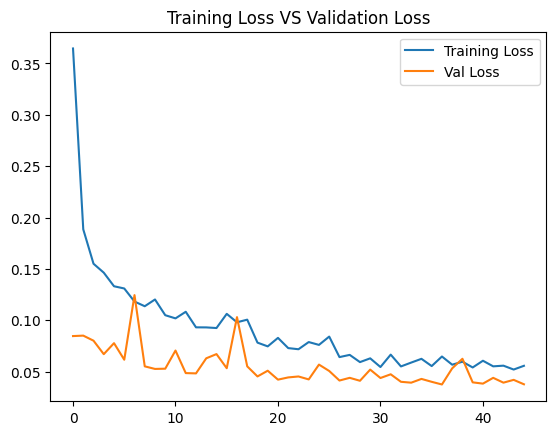

In [18]:
#Visulaise the result
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss VS Validation Loss")

Text(0.5, 1.0, 'Training Accuracy VS Validation Accuracy')

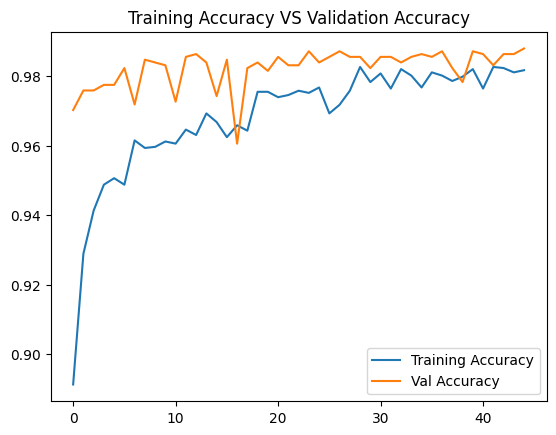

In [19]:
#Visulaise the result
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training Accuracy VS Validation Accuracy")

Text(0.5, 1.0, 'Training Recall VS Validation Recall')

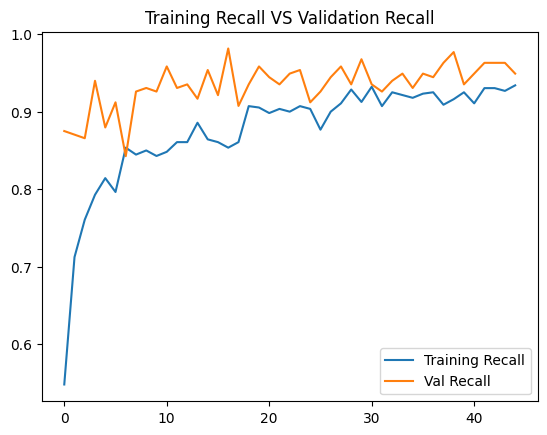

In [20]:
#Visulaise the result
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.legend()
plt.title("Training Recall VS Validation Recall")

Text(0.5, 1.0, 'Training Precision VS Validation Precision')

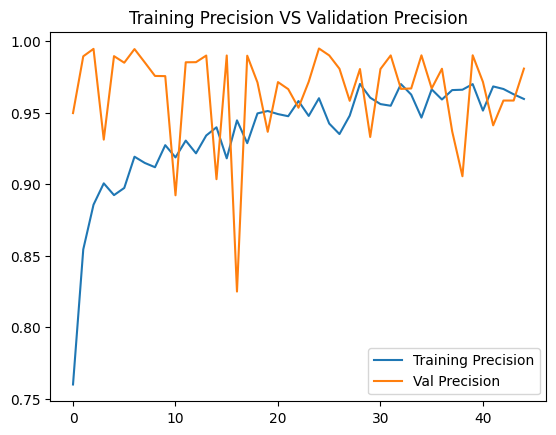

In [21]:
#Visulaise the result
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.legend()
plt.title("Training Precision VS Validation Precision")

**Model Evaluation**

In [22]:
test_ds = val_datagen.flow_from_directory(
    test_dir,
    target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size = 16,
    class_mode = 'binary',
    shuffle=False)

Found 138 images belonging to 2 classes.


In [40]:
test_labels = test_ds.classes
predictions = model.predict(test_ds)
predicted_classes = (predictions > 0.5).astype(int).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


In [43]:
report = classification_report(test_labels,predicted_classes,
                     target_names = list(test_ds.class_indices.keys()))

print(report)

              precision    recall  f1-score   support

      not_tb       0.99      1.00      1.00       114
          tb       1.00      0.96      0.98        24

    accuracy                           0.99       138
   macro avg       1.00      0.98      0.99       138
weighted avg       0.99      0.99      0.99       138



In [45]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_ds, verbose=2)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test Precision: {test_precision:.4f}')

# Get predictions on the test dataset
predictions = model.predict(test_ds)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Convert to binary

# Get true labels from the test dataset
true_classes = test_ds.classes

# Calculate F1 Score
f1 = f1_score(true_classes, predicted_classes)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(true_classes, predictions)

# Calculate AUC Score
roc_auc = auc(fpr, tpr)

# Print F1 Score and AUC Score
print(f'Test F1 Score: {f1:.4f}')
print(f'AUC Score: {roc_auc:.4f}')


9/9 - 1s - 160ms/step - accuracy: 0.9928 - loss: 0.0298 - precision: 1.0000 - recall: 0.9583
Test Loss: 0.0298
Test Accuracy: 0.9928
Test Recall: 0.9583
Test Precision: 1.0000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
Test F1 Score: 0.9787
AUC Score: 0.9989


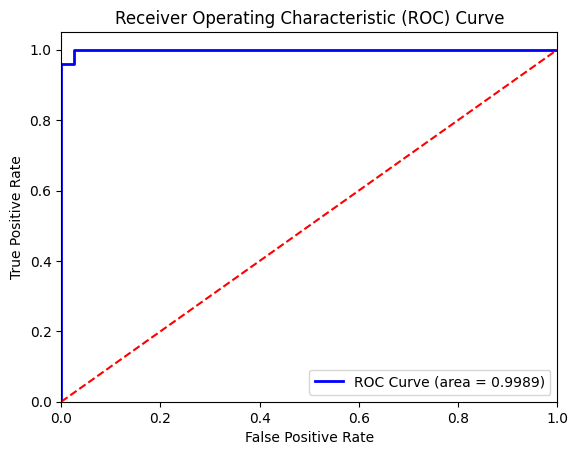

In [44]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

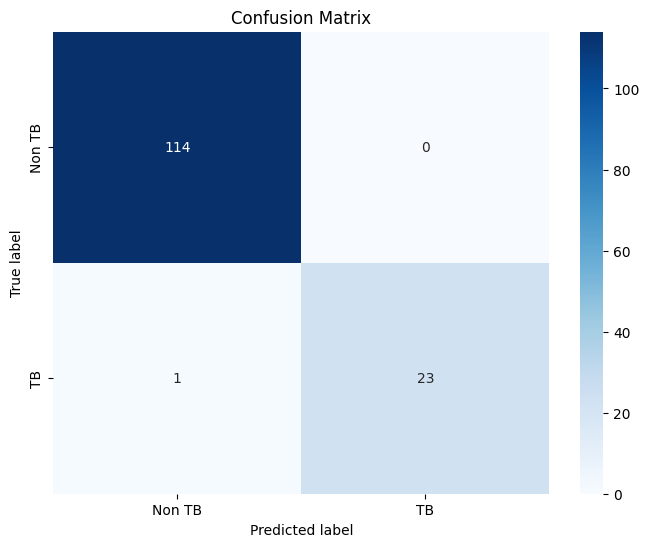

In [51]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
             xticklabels=['Non TB', 'TB'], 
             yticklabels=['Non TB', 'TB'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

**Saving the Model**

In [30]:
model.save('resnet_tuned_model.h5')